In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

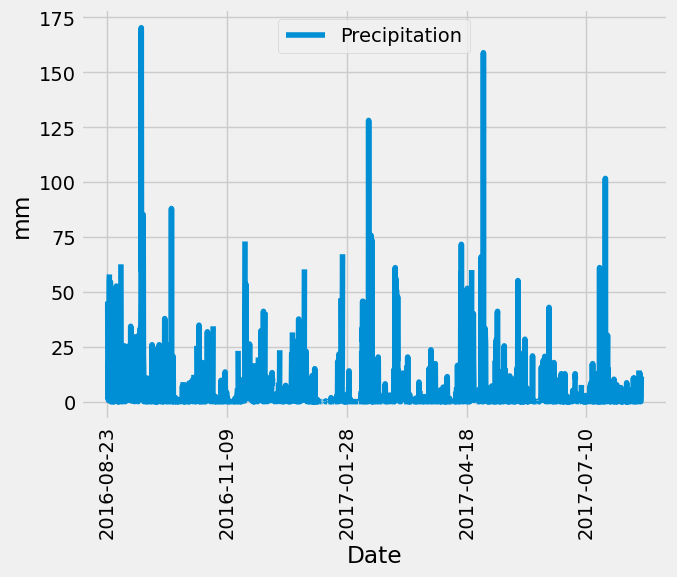

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')
one_year_ago_date = most_recent_date - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
columns = ['Date', 'Precipitation']
last_12_months_df = pd.DataFrame(results, columns=columns)

# Sort the dataframe by date
last_12_months_df = last_12_months_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
last_12_months_df.plot(x='Date', y='Precipitation', kind='line', figsize=(7, 6))
plt.xlabel('Date')
plt.ylabel('mm')
plt.xticks(rotation=90)
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = last_12_months_df['Precipitation'].describe()
summary_statistics

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order.
active_stations_list = []

for row in active_stations:
    active_stations_list.append((row[0], row[1]))

# Sort the list in ascending order based on the station counts (row[1])
active_stations_list = sorted(active_stations_list, key=lambda x: x[1], reverse=True)
active_stations_list

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]

# Perform a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_id).all()

# Unpack the results and put them in a list
temperature_stats_list = [temperature_stats[0]]

print(temperature_stats_list)

[(12.2, 29.4, 22.03582251082252)]


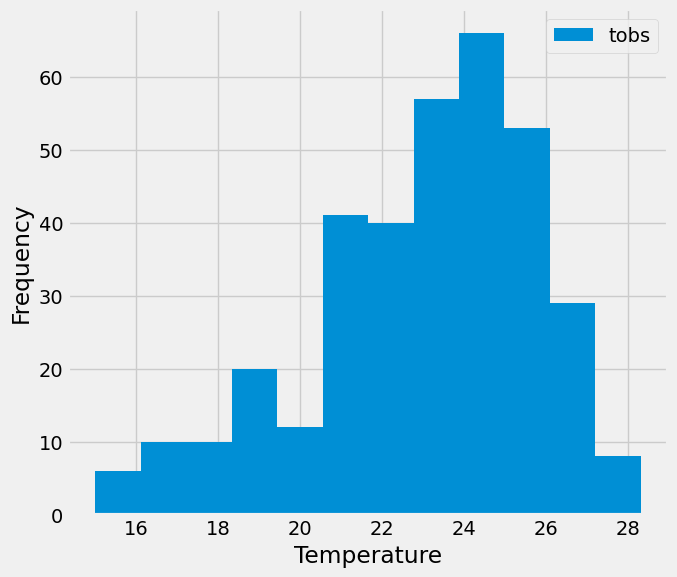

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Perform a query to retrieve the temperature observations for the most active station in the last 12 months
temperature_data = session.query(Measurement.tobs).filter(Measurement.station == most_active_station_id, Measurement.date >= one_year_ago_date).all()

# Extract temperatures from the result
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(7, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()